In [6]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as torch_optim
import torch.nn as nn
import torch.nn.functional as F

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Разбить модель на обучающую и валидационную (тестовую) выборки

In [8]:
from sklearn.model_selection import train_test_split

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

batch_size = 64
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

train_dataset, validation_dataset = train_test_split(train_data, test_size=0.30, random_state=54, stratify=train_data.targets)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


## Тренировка модели

In [9]:
def train_model(model, train_dataloader, val_dataloader, device, num_epochs=10, lr=10e-5, show=True):
    optimizer = torch_optim.Adam(model.parameters(), lr=lr)
    loss_function = nn.CrossEntropyLoss()

    train_losses = []
    val_losses = []

    for e in range(num_epochs):
        model.train()

        epoch_train_loss = 0

        for batch in train_dataloader:
            data, target = batch
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_function(output, target)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()

        model.eval()

        epoch_val_loss = 0
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_function(y_pred, y_batch)

            epoch_val_loss += loss.item()

        train_losses.append(epoch_train_loss / len(train_dataloader))
        val_losses.append(epoch_val_loss / len(val_dataloader))

    if show:
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 3))
        x = range(len(train_losses))
        ax1.plot(x, train_losses, label='Train')
        ax1.plot(x, val_losses, label='Val')
        ax1.set_title('Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        plt.show()

    model.to(device)

    correct = 0
    total = 0
    with torch.no_grad():
        for batch in test_dataloader:
            data, target = batch
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    return correct / total

def test(model, activation=F.relu, num_epochs=10, show=True):
    model.to(device)
    best_metric = train_model(model, train_dataloader, validation_dataloader, device, num_epochs=num_epochs, show=show)

    if show:
        print(f"Лучший результат на валидации: {best_metric}")

    return best_metric

### Модель только на полносвязных слоях (Dense)

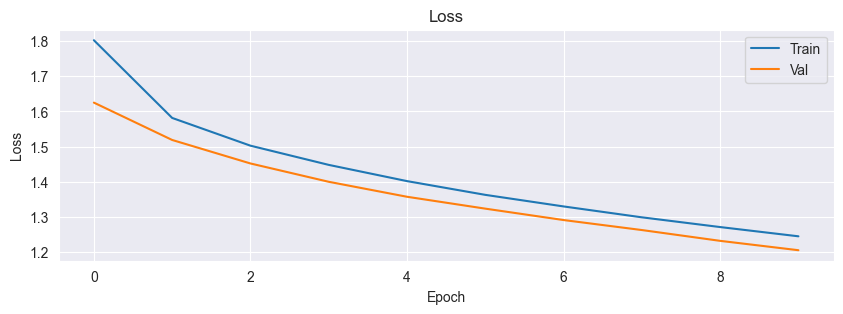

Лучший результат на валидации: 0.5249


0.5249

In [10]:
class DenseModel(nn.Module):
    def __init__(self):
        super(DenseModel, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

test(DenseModel(), num_epochs=10)

## Модель на сверточных слоях

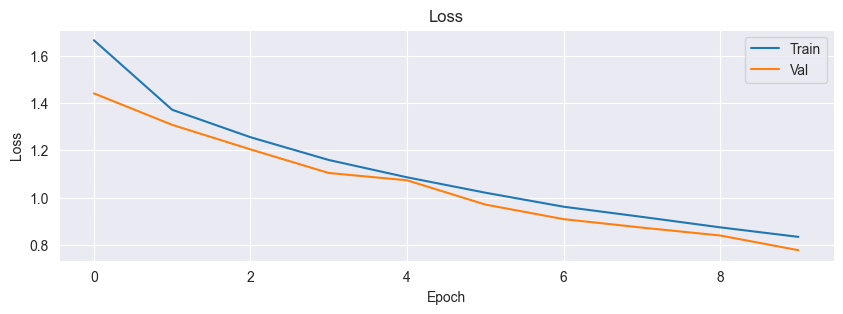

Лучший результат на валидации: 0.6929


0.6929

In [11]:
class ConvModel(nn.Module):
    def __init__(self):
        super(ConvModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * 128, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 4 * 4 * 128)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

test(ConvModel(), num_epochs=10)

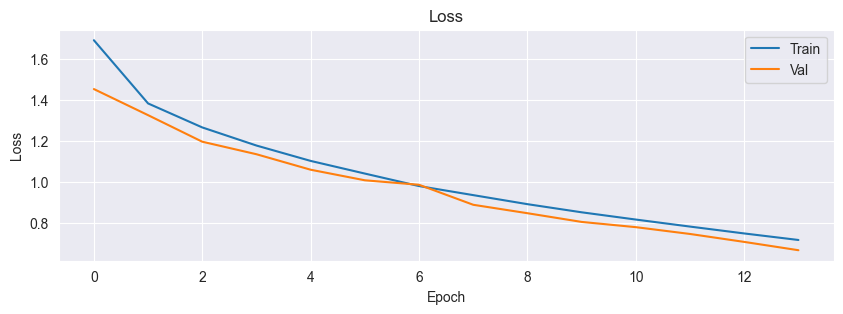

Лучший результат на валидации: 0.7134


0.7134

In [12]:
test(ConvModel(), num_epochs=14)

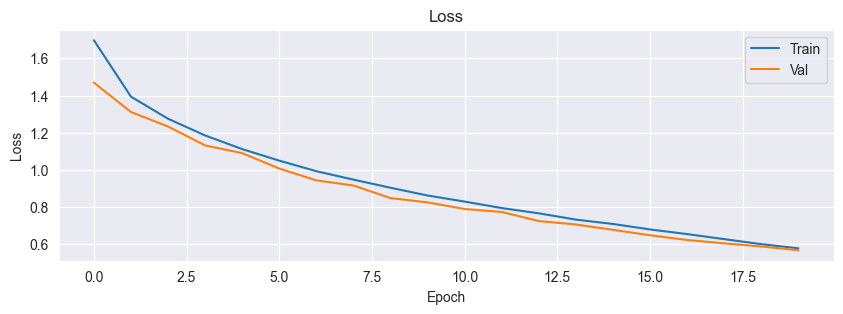

Лучший результат на валидации: 0.7262


0.7262

In [13]:
test(ConvModel(), num_epochs=20)

Как итог видим, что наиболее эффективным подходом является использование сверточных нейронных сетей.

Сверточные слои в CNN более эффектвно улавливают связи между пикселями в изображении. Это основная причина, почему результат получился лучше. Хотя есть и другие детали, которые влияют на обучение, например - в CNN меньше количество обучаемых параметров.